### 1. Function to simulate inventory

In [1]:
import numpy as np
import numpy.random as rd

def simulateOneRun(m, s, S,
    h = 0.1, #storage cost
    c = 2.0, #unit profit
    p = 0.5, #probability of delivery
    K = 40, # fixed order cost
    k = 1.0, # variable order cost
    average_demand = 20):
                   
    Xj = S #Stock in the morning
    Yj = None #  and in the evening.
    profit = 0.0 # Cumulated profit.
    lost_orders = 0
    inv_levs_history = []
    for j in range(m):
        Dj = rd.poisson(average_demand)
        Sj = min(Dj,Xj)
        lost_orders += max(0,Dj-Xj)
        Yj = Xj - Sj
        profit += c*Sj
        profit -= h*Yj
        if Yj <= s and rd.rand() < p:
            profit -= K
            profit -= k*(S-Yj)
            Yj = S
        Xj = Yj
        inv_levs_history.append(Yj)
    return (profit, lost_orders, inv_levs_history)

In [2]:
rd.seed(0)
days=80
reorder_point=100
res=simulateOneRun(days,reorder_point,400)
import matplotlib.pyplot as plt
plt.plot(range(days), res[2])
plt.plot([0,days-1], [reorder_point]*2) #[3]*10 <- returns a list with value 2
plt.show()

<Figure size 640x480 with 1 Axes>

### 2. Function to return average profits and lost orders

In [3]:
def simulateManyRuns(N,m,s,S):
    profits = np.zeros(N)
    lost_os = np.zeros(N)
    for i in range(N):
        res = simulateOneRun(m,s,S)
        profits[i] = res[0]
        lost_os[i] = res[1]
    return {
              "profit":(np.mean(profits),
                        np.std(profits)),
              "lost_orders":(np.mean(lost_os),
                        np.std(lost_os))
            }

In [4]:
rd.seed(0)
simulateManyRuns(100000,40,50,200)

{'profit': (292.85528200000005, 68.9511182686726),
 'lost_orders': (20.38755, 30.795624932731922)}

### 3. Create a list with target level and reorder point

In [5]:
# let us check for various values of s and S
rd.seed(0)
results = {}
for s in range(10,350,40): #reoder point
    for S in range(s+10,1050,40): #target warehouse level
        results[(s,S)] = simulateManyRuns(2000,40,s,S)

### 4. Profits scatterplot

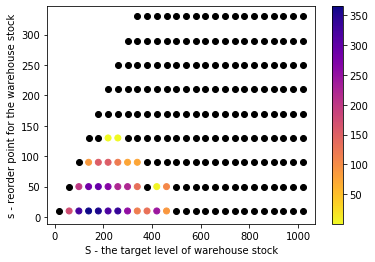

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sS=list(results.keys())
# positive profits
sSp=[t for t in sS if results[t]["profit"][0]>0]
# negative profits
sSn=[t for t in sS if results[t]["profit"][0]<=0]

# plot negative profits
plt.scatter([t[1] for t in sSn],[t[0] for t in sSn], 
            c="black")
# plot positive profits
plt.scatter([t[1] for t in sSp],[t[0] for t in sSp], 
            c=[results[t]["profit"][0] for t in sSp],
           cmap=cm.plasma_r)

plt.xlabel("S - the target level of warehouse stock")
plt.ylabel("s - reorder point for the warehouse stock")
plt.colorbar()
plt.show()

### 5. Lost order scatterplot

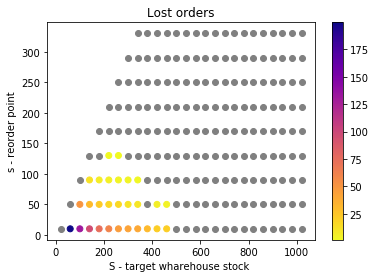

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
val_pos = [r for r in results.keys() if results[r]["profit"][0]>-0]
val_neg = [r for r in results.keys() if results[r]["profit"][0]<=-0]
plt.scatter([v[1] for v in val_pos],
            [v[0] for v in val_pos], 
            c=[results[v]["lost_orders"][0] for v in val_pos], cmap=cm.plasma_r )
plt.xlabel("S - target wharehouse stock ")
plt.ylabel("s - reorder point")
plt.colorbar()
plt.scatter([v[1] for v in val_neg],
            [v[0] for v in val_neg],
            c="gray")
plt.title("Lost orders")
plt.show()

### 6. Heatmap

#### Data preparation

In [8]:
#-----------------------------------------------------------------
# library
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *

#-----------------------------------------------------------------
# Replace all negative profits with 0
def replace_zero(x):
    if x>0:
        return x
    else:
        return 0

#-----------------------------------------------------------------
# 1. Data manipulation
# dictionary
heatmap_dict = {"x":[],
                "y":[],
                "profit":[],
                "lost_orders":[]
               }

# extracting values with positive profit
for values in results.keys():                           
    heatmap_dict["x"].append(values[1])
    heatmap_dict["y"].append(values[0])
    heatmap_dict["profit"].append(replace_zero(results[values]["profit"][0]))
    heatmap_dict["lost_orders"].append(results[values]["lost_orders"][0])
heatmap_profit=pd.DataFrame.from_dict(heatmap_dict).pivot('y', 'x', 'profit')
heatmap_lost_orders=pd.DataFrame.from_dict(heatmap_dict).pivot('y', 'x', 'lost_orders')

# Alternatively the loop can be run for positive profits (vals_pos). In that case replace all NaNs
#NaN_list = isnan(heatmap)
#heatmap[NaN_list] = 0

#### Heatmap for profits

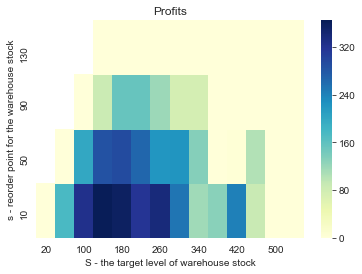

In [13]:
import seaborn as sns
sns.set_style("whitegrid")
ax=sns.heatmap(heatmap_profit, cmap=r"YlGnBu")

# labels
plt.xlabel("S - the target level of warehouse stock")
plt.ylabel("s - reorder point for the warehouse stock")
plt.title("Profits")

# axis manipulation
ax.invert_yaxis()
ax.axes.set_ylim(0, 4)
ax.axes.set_xlim(0, 14)

# output
plt.savefig(r"C:\Users\bachy\Courses\Advanced simulation modelling\3 lecture\profit.png")
plt.show()

#### Heatmap for lost orders

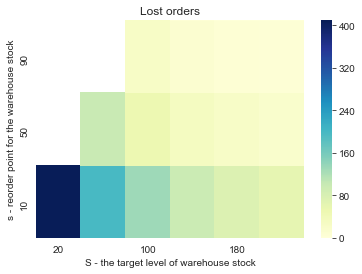

In [10]:
import seaborn as sns
sns.set_style("whitegrid")
ax=sns.heatmap(heatmap_lost_orders, cmap=r"YlGnBu")

# labels
plt.xlabel("S - the target level of warehouse stock")
plt.ylabel("s - reorder point for the warehouse stock")
plt.title("Lost orders")

# axis manipulation
ax.invert_yaxis()
ax.axes.set_ylim(0, 3)
ax.axes.set_xlim(0, 6)

# output
plt.savefig(r"C:\Users\bachy\Courses\Advanced simulation modelling\3 lecture\lost_order.png")
plt.show()

## 7. Return best result

In [11]:
best_key = None
best_profit = 0
for key in results.keys():
    if results[key]["profit"][0] > best_profit:
        best_profit =  results[key]["profit"][0]
        best_key = key      

print("Best decision: " ,best_key)
print("Best outcome:", results[best_key])

Best decision:  (10, 140)
Best outcome: {'profit': (364.77615000000003, 64.14448983488371), 'lost_orders': (96.554, 49.70493017800146)}


## 8. Plot profit vs lost order

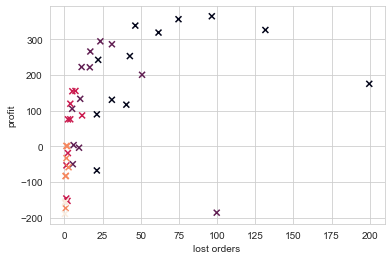

In [12]:
keys = [k for k in results.keys() if results[k]["profit"][0]>-200]
prs = [results[key]["profit"][0] for key in keys]
los = [results[key]["lost_orders"][0] for key in keys]
ss = [k[0] for k in keys]

import matplotlib.pyplot as plt

plt.scatter(los,prs, marker='x', c = ss)
plt.xlabel("lost orders")
plt.ylabel("profit")
plt.show()